In [2]:
import os
import json
import math
import transformers
import random
import torch

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cbook as cbook

from transformers import AdamW, Adafactor
from tqdm.notebook import tqdm
from mkultra.tuning import GPT2PromptTuningLM
from mkultra.tokenizers import GPT2SPTokenizerFast
from mkultra.soft_prompt import SoftPrompt

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'GPT2Tokenizer'. 
The class this function is called from is 'GPT2SPTokenizerFast'.


In [ ]:
model = GPT2PromptTuningLM.from_pretrained("gpt2").half().to("cuda")
tokenizer = GPT2SPTokenizerFast.from_pretrained("gpt2")

In [3]:
df = pd.read_csv('paraphrase-dataset.csv', sep=',')

inputs = df['input'].to_list()
target = df['target'].to_list()

with open('paraphrase-dataset.txt', 'w') as outfile:
    for i in range(len(df)):
        outfile.write(f'Sentence : {inputs[i]}\nParaphrase : {target[i]}\n\n')

In [4]:
#----------------------------#
#  Prompt Tuning Parameters  #
#----------------------------#

# This decides the length of your soft prompt in tokens.
# They will be initialized from the first n tokens of your dataset.
n_tokens = 20

initial_prompt = """A paraphrase is a different way to say the same thing. Paraphrase the following sentence.\n"""

if initial_prompt is not None:
    print(f"Initial prompt length: {len(tokenizer.encode(initial_prompt))} tokens")

# Decide the length of your training blocks in tokens.
# Safe sizes for gpt-neo-2.7B-halved:
#  - 700 on a Colab T4 (16GB)
#  - 400 on a Colab K80 (12GB)
#  - 32 on a GTX1080 (8GB)
# If it seems a bit small, don't worry!
# Soft prompts can be moved forward in context for the best effect.
block_size = 32

# Name your soft prompt project.
sp_name = 'prompt-tuning-paraphrase-2'

# What's the name of model you'll be using?
model_name = 'gpt2'

# Specify the model directory or huggingface name.
model_dir = "gpt2"

model_type = "gpt2"

# Specify the path to the text file used for training.
text_path = "paraphrase-dataset.txt"

# Specify the project directory.
project_dir = f"./{sp_name}-{model_name}/"

# Checkpoint interval in steps.
checkpoint_interval = 1

# Evaluation interval in steps.
eval_interval = 1

# How many blocks to use for evaluation.
eval_blocks = 20

# Adafactor hyperparameters
optimizer_params = {
    # Fixed learning rate, recommend 1e-4 to 1e-3
    "lr": 1e-3,
    
    # 1st momentum, recommend 0
    "beta1": 0,

    # 2nd momentum decay schedule, recommend -0.3 (lower is slower)
    "decay_rate": -0.3,

    # Weight decay, recommend 1e-2 (WI is sensitive to overfitting)
    "weight_decay": 1e-2,
    
    # Update scaling, recommend False
    "scale_parameter": False,
    
    # Built-in LR scheduler, recommend False
    "relative_step": False
    }

# Gradient accumulation steps.
base_acc_steps = 30

# Gradient accumulation schedule.
# If '0', use a fixed gradient accumulation.
acc_doubling_rate = 0

# Stop training after this many evals without improvement.
# If '0', don't stop early.
plateau_steps = 10

scheduler_params = {
   "num_warmup_steps": 10,
   "num_cycles": 4,
   "num_training_steps": 500
}

Initial prompt length: 21 tokens


In [5]:
filename_for_checkpoint = lambda step: f"{sp_name}-{model_name}-step-{step}.json"
loaded_sp = None
project_files = None

# Look for existing project directory
try:
    os.makedirs(project_dir)
    print(f"Created project directory at {project_dir}")
except FileExistsError:
    print(f"Found project directory at {project_dir}")

# Look for existing checkpoints
project_files = os.listdir(project_dir)
if project_files is not None:
    checkpoint_files = [check_file for check_file in project_files if ('-step-' in check_file) ]

    if len(checkpoint_files) > 0:
        highest_step = max([ int(check_file[check_file.rfind('-step-')+6:-5]) for check_file in checkpoint_files ])
        loaded_sp = SoftPrompt.from_file( os.path.join(project_dir, filename_for_checkpoint(highest_step)) )
        print(f"Loading latest checkpoint: {highest_step}")
    else:
        print("No checkpoints found")

2023-03-10 13:48:31.033814: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-10 13:48:31.033848: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


Created project directory at ./prompt-tuning-paraphrase-2-gpt2/
No checkpoints found


In [6]:
text_tokenized = None
tokens_path = os.path.join(project_dir,"tokens.json")

# See if we already have a tokens file
try:
    with open(tokens_path, 'r', encoding='utf-8') as file:
        text_tokenized = json.load(file)
        print("Loaded existing tokens.json file")

except FileNotFoundError:
    print("No tokens.json exists, creating it...")

# If not, make one now
if text_tokenized is None:

    with open(text_path, 'r', encoding='utf-8') as file:
        text = file.read()
    text_tokenized = tokenizer.encode(text)
    
    with open(tokens_path, 'x', encoding='utf-8') as file:
        json.dump(text_tokenized, file)

text_length = len(text_tokenized)
num_blocks = math.ceil(text_length/block_size)

print(f"Length of text: {len(text_tokenized)} tokens")
print(f"Number of blocks: {num_blocks}, each {block_size} tokens")

# Partition tokens into blocks
blocks = list()
for block_num in range(num_blocks):
    start = block_num * block_size
    end = min(start + block_size, text_length)
    blocks.append( text_tokenized[start:end] )

block_order_path = os.path.join(project_dir, "block_order.json")

# See if we already have a block_order file
try:
    with open(block_order_path, 'r', encoding='utf-8') as file:
        block_order = json.load(file)
        print("Loaded existing block_order.json file")

except FileNotFoundError:
    print("No block_order.json exists, creating it...")
    block_order = [*range(num_blocks)]

    with open(block_order_path, 'x', encoding='utf-8') as file:
        json.dump(block_order, file)

Token indices sequence length is longer than the specified maximum sequence length for this model (39144 > 1024). Running this sequence through the model will result in indexing errors


No tokens.json exists, creating it...
Length of text: 39144 tokens
Number of blocks: 1224, each 32 tokens
No block_order.json exists, creating it...


In [7]:
if loaded_sp is None:
    if initial_prompt is None:
        model.initialize_soft_prompt(n_tokens=n_tokens)
    else:
        initial_sp = SoftPrompt.from_string(initial_prompt, model, tokenizer)
        print(f"Initial prompt length: {len(initial_sp)}")
        model.set_soft_prompt(initial_sp)

    sp_step = 0
    eval_loss = 100
else:
    model.set_soft_prompt(loaded_sp)
    sp_step = loaded_sp._metadata['step']
    eval_loss = loaded_sp._metadata['loss']
    
num_training_steps = scheduler_params['num_training_steps']

Initial prompt length: 21


In [8]:
# Feed soft params to optimizer
optimizer_params['params'] = [model.get_soft_params()]
optimizer = Adafactor(**optimizer_params)
optimizer.state['step'] = sp_step

scheduler_params['optimizer'] = optimizer
scheduler = transformers.get_cosine_with_hard_restarts_schedule_with_warmup(**scheduler_params)

In [9]:
torch.cuda.empty_cache()
loss_log_path = os.path.join(project_dir,"loss_log.csv")
bar = tqdm(total=num_training_steps)
optimizer.state['step'] = sp_step
evals_since_last_improvement = 0
best_eval = float('inf')

# Fix eval order
eval_order = [*range(num_blocks)]
random.seed(1234)
random.shuffle(eval_order)

# Function for gradient accumulation scheduling
def get_acc_steps(sp_step):
    if acc_doubling_rate != 0:
        return round(base_acc_steps * math.pow(2, (sp_step / acc_doubling_rate)))
    else:
        return base_acc_steps

for session_step in range(num_training_steps):
      model.train()
      print(f"epoch : {session_step+1}")

      acc_steps = get_acc_steps(sp_step)

      for i in range(acc_steps):
          idx = (sp_step*acc_steps + i) % num_blocks

          # Shuffle blocks every epoch
          if idx == 0:
              random.shuffle(block_order)
              with open(block_order_path, 'w', encoding='utf-8') as file:
                  json.dump(block_order, file)

          block = blocks[block_order[idx]]

          input_ids = torch.LongTensor(block).unsqueeze(0).cuda().detach()
          
          # Forward pass and optimize
          outputs = model(input_ids=input_ids, labels=input_ids)
          loss = outputs.loss
          loss.backward()

          instant_loss = loss.item()
          if math.isnan(instant_loss):
              torch.cuda.empty_cache()
              raise KeyboardInterrupt

          # Discard tensor that was moved to GPU
          del input_ids
          torch.cuda.empty_cache()

      # Accumulate gradients
      optimizer.step()
      lr = optimizer.param_groups[0]["lr"]
      scheduler.step()
      optimizer.zero_grad()

      if math.isnan(instant_loss):
          torch.cuda.empty_cache()
          raise KeyboardInterrupt

      # Evaluate model and plot loss
      if sp_step%eval_interval == 0:
          model.eval()
          torch.cuda.empty_cache()
          eval_loss = 0

          with torch.no_grad():
              for eval_step in range(eval_blocks):
                  block = blocks[eval_order[eval_step]]
                  input_ids = torch.LongTensor(block).unsqueeze(0).cuda().detach()
                  eval_loss += model(input_ids=input_ids, labels=input_ids).loss.item()
                  
                  # Discard tensor that was moved to GPU
                  del input_ids
                  torch.cuda.empty_cache()

          eval_loss /= eval_blocks

          with open(loss_log_path, 'a', encoding='utf-8') as file:
              file.write(f"{sp_step},{eval_loss}\n")
          
          # Stop if loss has plateaued
          if plateau_steps != 0:
              if eval_loss < best_eval:
                  best_eval = eval_loss
                  evals_since_last_improvement = 0
              else:
                  evals_since_last_improvement += 1
              if evals_since_last_improvement > plateau_steps:
                  print(f"No improvement for {plateau_steps} evals")
                  break

      # Save checkpoint every so often
      if sp_step%checkpoint_interval == 0:
          sp = SoftPrompt.from_tuning_model(model,
              {"name" : sp_name + f"-step-{sp_step}",
               "step"  : sp_step,
               "loss"  : eval_loss})
          sp.to_file( os.path.join( project_dir,filename_for_checkpoint(sp_step) ) )

      bar.set_postfix({
          "Model Step" : sp_step,
          "Eval Loss"  : "{el:.5f}".format(el=eval_loss),
          "Acc Steps"  : acc_steps,
          "LR"         : lr
      })
      bar.update(1)
      sp_step += 1

# Save a checkpoint once done
sp = SoftPrompt.from_tuning_model(model,
    {"name"  : sp_name + f"-step-{sp_step}",
     "step"  : sp_step,
     "loss"  : eval_loss})
sp.to_file( os.path.join( project_dir,filename_for_checkpoint(sp_step) ) )

  0%|          | 0/500 [00:00<?, ?it/s]

epoch : 1
epoch : 2
epoch : 3
epoch : 4
epoch : 5
epoch : 6
epoch : 7
epoch : 8
epoch : 9
epoch : 10
epoch : 11
epoch : 12
epoch : 13
epoch : 14
epoch : 15
epoch : 16
epoch : 17
epoch : 18
epoch : 19
epoch : 20
epoch : 21
epoch : 22
epoch : 23
epoch : 24
epoch : 25
epoch : 26
epoch : 27
epoch : 28
epoch : 29
epoch : 30
epoch : 31
epoch : 32
epoch : 33
epoch : 34
epoch : 35
epoch : 36
epoch : 37
epoch : 38
epoch : 39
epoch : 40
epoch : 41
epoch : 42
epoch : 43
epoch : 44
epoch : 45
epoch : 46
epoch : 47
epoch : 48
epoch : 49
epoch : 50
epoch : 51
epoch : 52
epoch : 53
epoch : 54
epoch : 55
epoch : 56
epoch : 57
epoch : 58
epoch : 59
epoch : 60
epoch : 61
epoch : 62
epoch : 63
epoch : 64
epoch : 65
epoch : 66
epoch : 67
epoch : 68
epoch : 69
epoch : 70
epoch : 71
epoch : 72
epoch : 73
epoch : 74
epoch : 75
epoch : 76
epoch : 77
epoch : 78
epoch : 79
epoch : 80
epoch : 81
epoch : 82
epoch : 83
epoch : 84
epoch : 85
epoch : 86
epoch : 87
epoch : 88
epoch : 89
epoch : 90
epoch : 91
epoch : 

In [10]:
try:
  del input_ids
except Exception:
  pass

torch.cuda.empty_cache()

min loss reached at 361 epoch.


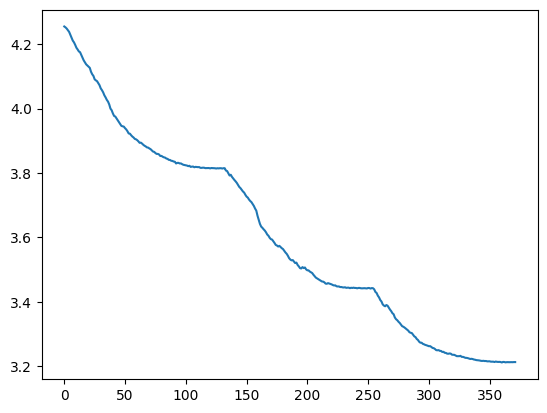

In [11]:
# Plot loss
with open(loss_log_path, 'r') as file:
    array = np.loadtxt(file, delimiter=",")

fig = plt.figure()
plt.plot(array[:, 0], array[:, 1])

colnames = ['index', 'loss'] 
losses = pd.read_csv(loss_log_path, sep=',', index_col = [0], names = colnames)
min_loss = min(losses['loss'])
min_loss_idx = losses.index[losses['loss'] == min_loss][0]+1

print(f'min loss reached at {min_loss_idx} epoch.')

In [12]:
# Try generating with your model
model.eval()

# Restore soft prompt from checkpoint
# (Use above graph to find a good stopping point and check project directory for valid checkpoints)
sp = SoftPrompt.from_file(os.path.join(project_dir, filename_for_checkpoint(min_loss_idx)) )
model.set_soft_prompt(sp)

test = "Sentence : What's the weather like today ?\nParaphrase :"

call = tokenizer(test, return_tensors="pt").input_ids.cuda()

basic_output = model.generate(
    input_ids=call,
    do_sample=True,
    min_length=call.shape[-1] + 200,
    max_length=call.shape[-1] + 200,
    temperature=1.0,
    tfs = 0.9,
    repetition_penalty = 3.0,
    pad_token_id=tokenizer.eos_token_id
)
print(tokenizer.decode(basic_output[0]))

Sentence : What's the weather like today?
Paraphrase : How to get around in New South Wales? Paraphernalia: what kinds do you have at this hour, which ones are they getting rid of and why has it become popular with teenagers. Sentences:-What was going on yesterday that caused my wife (not her husband) suffering such a big headache as I can't believe how bad things felt inside me..sentencing:-Whois your name & date from who or where did i come across these pictures?:My Wife Has Been Hailing From Tasmania So Windy At Work For The Day/Night... Reply - Follow- Quote This is very hard news for Australia because there aren�t adequate facilities under Australian laws __________________

The first answer will be given when she returns home after having been through all those years´s work. You remember last time we were doing laundry some people showed up too late so our hair got stained red pretty quickly! In contrast you never know before but maybe soon every one here might see about ten more